In [158]:
import this

In [159]:
import math
from pprint import pprint as pp

In [160]:
math.log(1)

0.0

### finance & py syntax

In [161]:
#### options params
S0 = 100.  # <1>
K = 105.  # <1>
T = 1.0  # <1>
r = 0.05  # <1>
sigma = 0.2  # <1>

In [162]:
import math
import numpy as np  # <2>

I = 1000000
%time
np.random.seed(1000)  # setting the seed
z = np.random.standard_normal(I)  # <4>  #len of 100 K
ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * z)  #vectorized
hT = np.maximum(ST - K, 0)  # <6>
C0 = math.exp(-r * T) * np.mean(hT)  ##aggregate on a vector

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [163]:
pp('european call option value: {}'.format(C0))

'european call option value: 8.01361463852807'


### tyme to results

In [164]:
import pandas as pd

In [165]:
## chart params
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [166]:
df = pd.read_csv('../../data/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)  # <2>

In [167]:
## df.head(2)
## extract SPX from list of instruments
data = pd.DataFrame(df['.SPX'])  # <3>
data.info()  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 1 columns):
.SPX    2138 non-null float64
dtypes: float64(1)
memory usage: 34.6 KB


In [168]:
## compute repturs  data.shift(1) is a lagged return
data['rets'] = np.log(data / data.shift(1))  # <5>
data.dropna(inplace=True)
#data['rets'].isnull().sum()  #checking if there are null vaulues

## 1-year window vol annualized (we need to drop na)
data['vola'] = data['rets'].rolling(252).std() * np.sqrt(252) 

data.tail(3)

,.SPX,rets,vola
Date,,,
2018-06-27,2699.63,-0.008642,0.122351
2018-06-28,2716.31,0.006160,0.122446
2018-06-29,2718.37,0.000758,0.122446


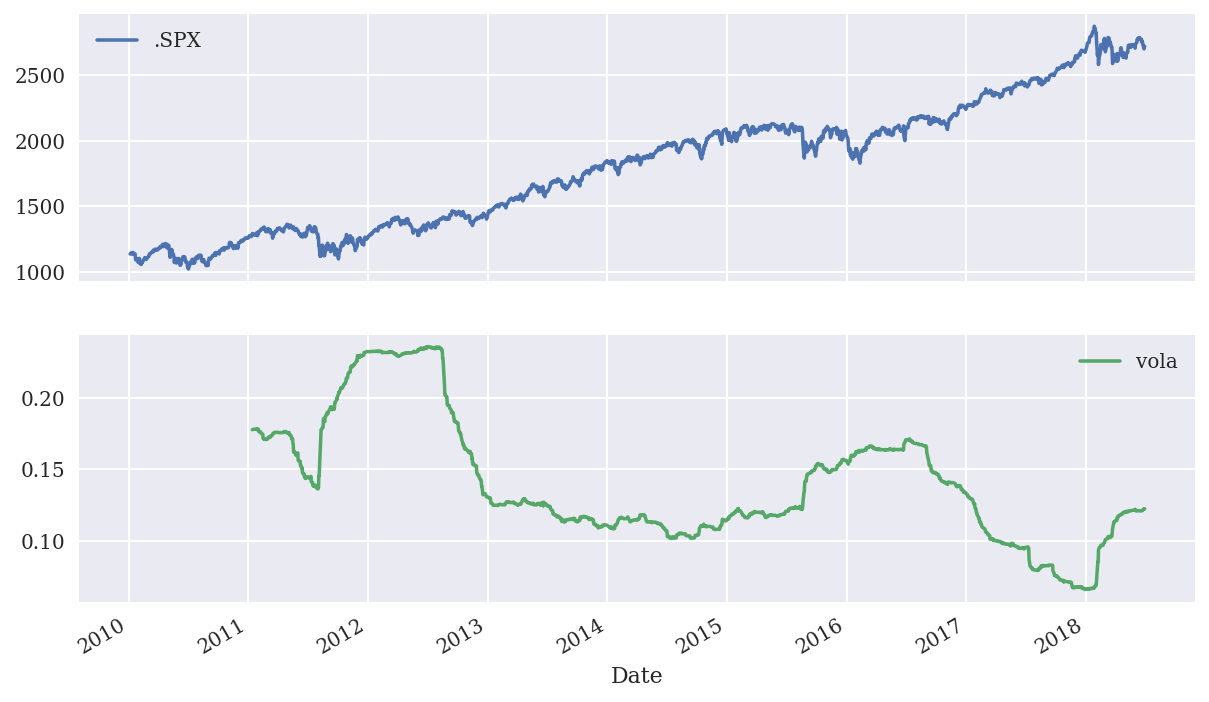

In [169]:
data[['.SPX', 'vola']].plot(subplots=True, figsize=(10, 6));

### explanation of log returns

In [170]:
ST = 110
ST / S0 - 1 #return of 10%  110 / 100 - 1

0.10000000000000009

In [171]:
r = math.log(ST/S0)  ##continuous return
r

0.09531017980432493

In [172]:
math.exp(r)  

1.1

In [173]:
math.exp(r) - 1

0.10000000000000009

### Paradigm vectorized computations

In [174]:
## pure pythong
loops = 2500000
import math
a = range(1, loops)
def f(x):
    return 3 * math.log(x) + math.cos(x) ** 2
%timeit r = [f(x) for x in a]

1.55 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [175]:
##vectorized
a = np.arange(1, loops)
%timeit r = 3 * np.log(a) + np.cos(a) ** 2

94.5 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [176]:
## even vaster
import numexpr as ne
ne.set_num_threads(1)
f = '3 * log(a) + cos(a) ** 2'
%timeit r = ne.evaluate(f)

46.1 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [177]:
## multi-threaded event faster
ne.set_num_threads(4)
%timeit r = ne.evaluate(f)

22 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### ML  dummy example

In [178]:
data = pd.DataFrame(df['AAPL.O']) 
#data = pd.DataFrame(df['.SPX'])   #test also worked
data['Returns'] = np.log(data / data.shift())  
data.dropna(inplace=True)

lags = 6
cols = []

for lag in range(1,lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = np.sign(data['Returns'].shift(lag))
    cols.append(col)
data.dropna(inplace=True)

data.tail(2)

,AAPL.O,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,,
2018-06-28,185.50,0.007250,-1.0,1.0,-1.0,-1.0,-1.0,1.0
2018-06-29,185.11,-0.002105,1.0,-1.0,1.0,-1.0,-1.0,-1.0


In [179]:
from sklearn.svm import SVC

In [180]:
model = SVC()

In [181]:
##cols contains signs of 6 lagged returns
##fast training 150 ms  !!NB no separation to train and test
model.fit(data[cols], np.sign(data['Returns']))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [182]:
data['Prediction'] = model.predict(data[cols])
data.tail(3)

,AAPL.O,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Prediction
Date,,,,,,,,,
2018-06-27,184.16,-0.001465,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
2018-06-28,185.50,0.007250,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0
2018-06-29,185.11,-0.002105,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0


In [183]:
data['Strategy'] = data['Prediction'] * data ['Returns']

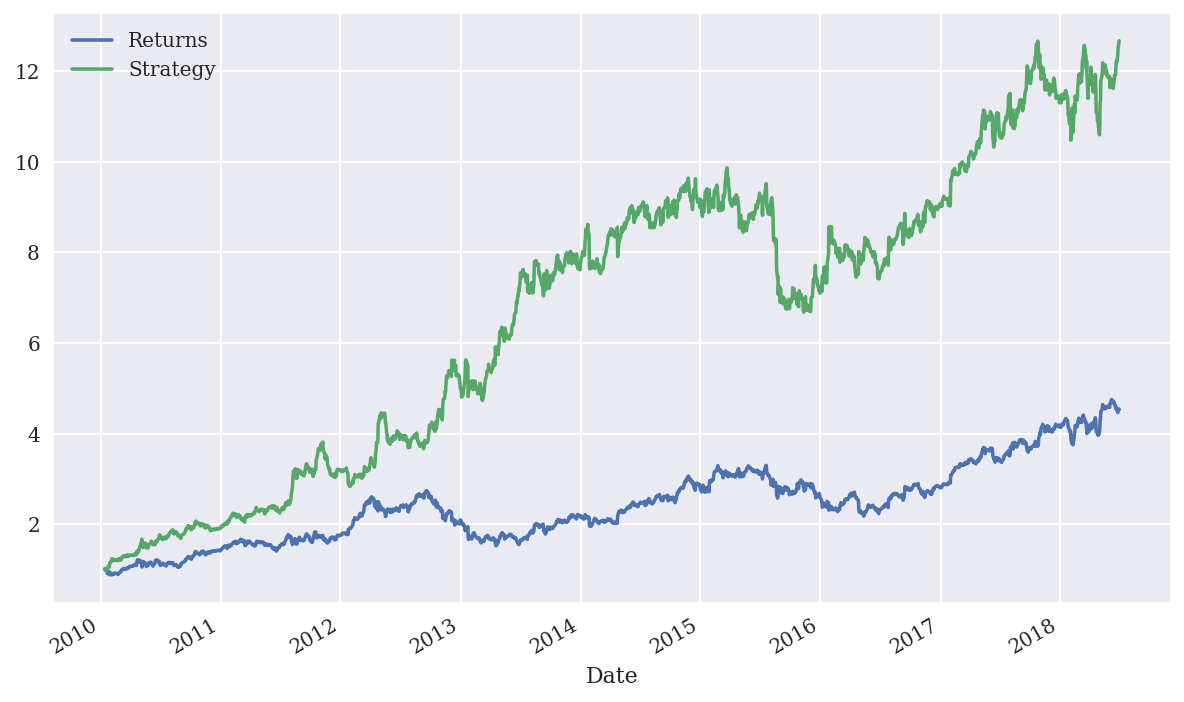

In [184]:
data[['Returns','Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6));

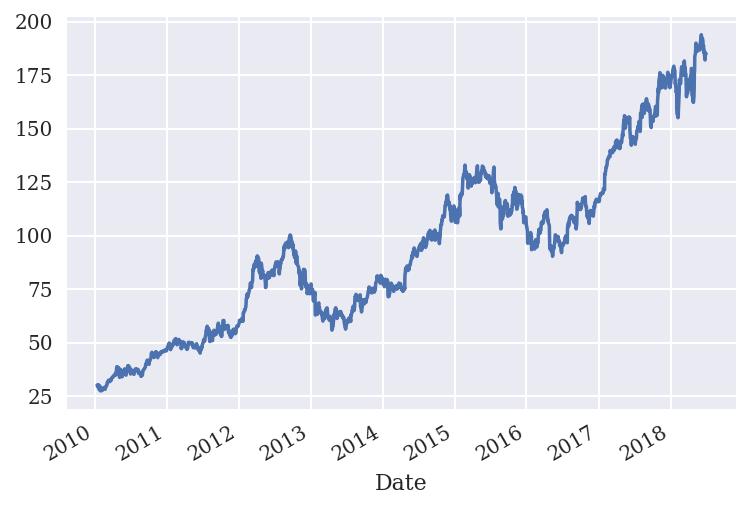

In [186]:
data['AAPL.O'].plot()